In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.read_csv("subject-info.csv")
df2 = pd.read_csv("test_measure.csv")

#merging df1 &df2 as df3
merged_df = df1.merge(df2, on=['ID', 'ID_test'], how='inner')
#save merge file as new csv file
merged_df.to_csv('merged_subject_test.csv', index=False)
df3 = pd.read_csv('merged_subject_test.csv')
df3.head(10)

df3 = pd.read_csv('merged_subject_test.csv')

### Q1.Identify Outliers in VE

           VE
9061    167.6
9062    168.2
9063    167.9
9064    169.2
9065    168.0
...       ...
565977  184.8
565978  183.0
565979  176.0
565980  172.5
565981  167.8

[1456 rows x 1 columns]


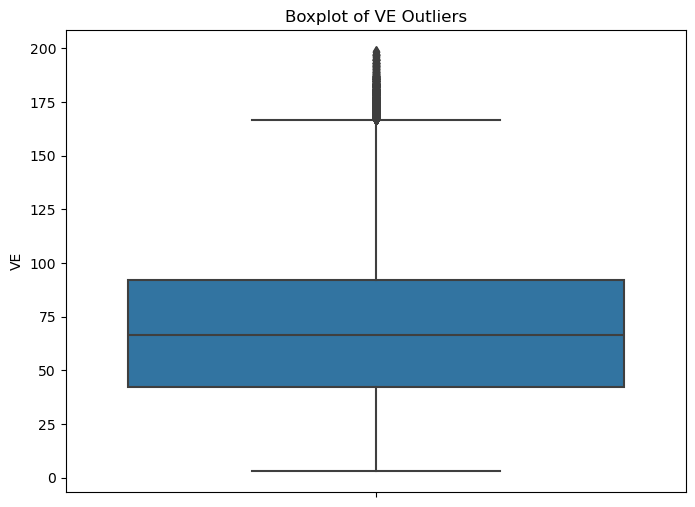

In [4]:
df2_copy = df2.copy()

# Assuming df2 is your DataFrame
Q1 = df2_copy['VE'].quantile(0.25)
Q3 = df2_copy['VE'].quantile(0.75)
IQR = Q3 - Q1
#Q1(First Quartile): 25th percentile of the 'VE' data, which means 25% of the data points are below this value.​
#Q3 (Third Quartile):75th percentile, indicating that 75% of the data points are below this value.​
#IQR (Interquartile Range): Calculated as Q3 - Q1, the IQR measures the spread of the middle 50% of the data.​

#outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#outliers
outliers = df2_copy[(df2_copy['VE'] < lower_bound) | (df2_copy['VE'] > upper_bound)]

#print the outlier
print(outliers[['VE']])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(y=df2['VE'])
plt.title('Boxplot of VE Outliers')
plt.ylabel('VE')
plt.show()



### Q2.Generate heatmaps to visualize how correlations between different physiological metrics change over the duration of the exercise tests.

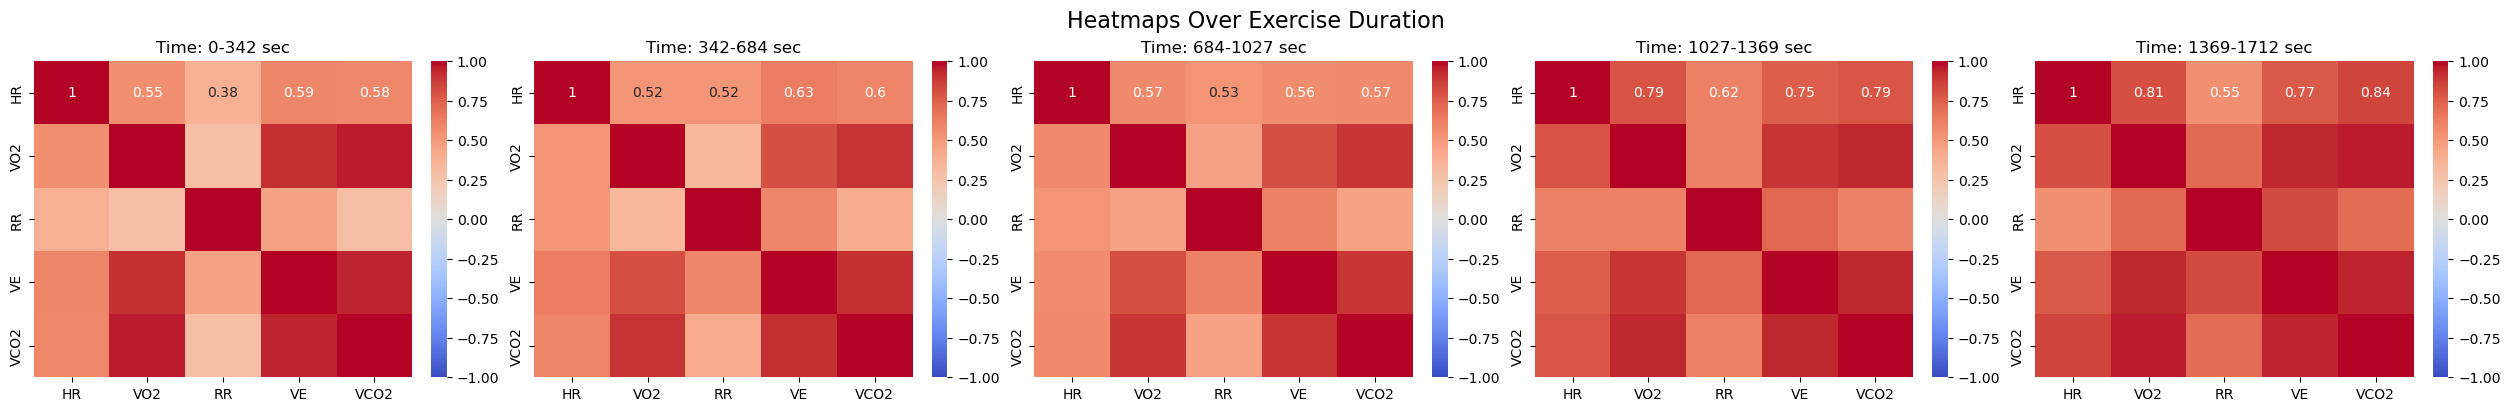

In [5]:
df2_copy = df2.copy()

# Define the number of intervals
num_intervals = 5

#Calculate the maximum time to set interval ranges
max_time = df2_copy['time'].max()

#Create time bins
time_bin = pd.interval_range(start=0, end=max_time, periods=num_intervals)

#Assign each row to a time bin
df2_copy['Time_Bin'] = pd.cut(df2_copy['time'], bins=time_bin)

# Define the physiological metrics to include in the correlation analysis
metrics = ['HR', 'VO2', 'RR', 'VE', 'VCO2']

#matplotlib figure
fig, axes = plt.subplots(1, num_intervals, figsize=(5 * num_intervals, 4), constrained_layout=True)

#time bin and plot the corresponding heatmap
for i, time_bin in enumerate(time_bin):
    # Filter data for the current time bin
    df_bin = df2_copy[df2_copy['Time_Bin'] == time_bin]
    
    #correlation matrix
    corr_matrix = df_bin[metrics].corr()
    
    #heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Time: {int(time_bin.left)}-{int(time_bin.right)} sec')

plt.suptitle('Heatmaps Over Exercise Duration', fontsize=16)
plt.show()
plt.close()


### Q3.Who has the lowest Speed during Peak Exercise?

In [6]:
df3_copy = df3.copy()

# Calculate RR
df3_copy['RER'] = df3_copy['VCO2'] / df3_copy['VO2']

#Define exercise phases 
def exercise_phases(RER):
    if RER < 0.85:
        return 'warmup'
    elif 0.85 <= RER < 1.00:
        return 'moderate'
    else:
        return 'peak exercise'

# Apply the function to create a new column for exercise phases
df3_copy['exercise_phases'] = df3_copy['RER'].apply(exercise_phases)


#Filter for Peak Exercise Phase
peak_exercise = df3_copy[df3_copy['exercise_phases'] == 'peak exercise']

#average speed per athlete
average_speed = peak_exercise.groupby(['ID', 'Sex'])['Speed'].mean().round(2).reset_index()
average_speed.rename(columns={'Speed': 'Average_Speed'}, inplace=True)

#Identify the athlete with the lowest average speed for each gender
lowest_speed_athletes = average_speed.loc[average_speed.groupby('Sex')['Average_Speed'].idxmin()]

print("Athletes with lowest average speed during peak exercise by gender:")
print(lowest_speed_athletes)



Athletes with lowest average speed during peak exercise by gender:
      ID  Sex  Average_Speed
234  235    0           4.86
96    97    1           5.00


### Q4.Create a point plot on age against BMI

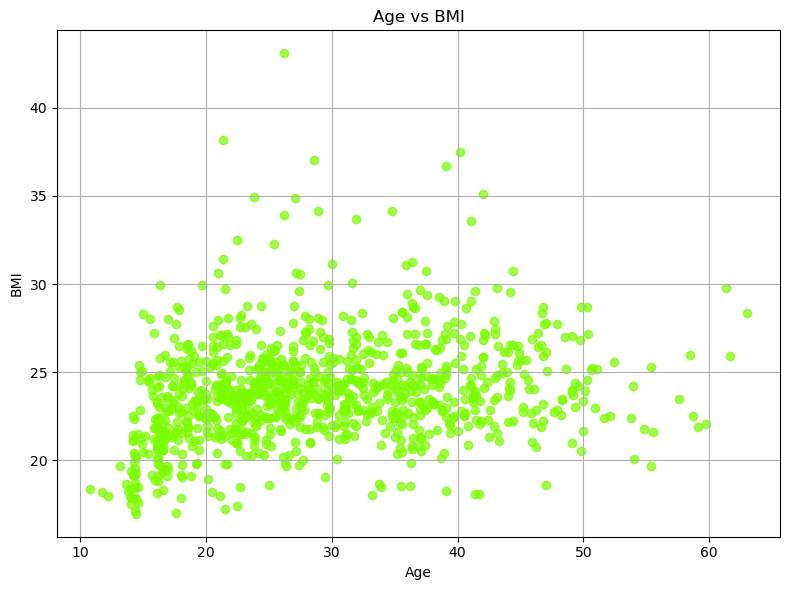

In [7]:
df1_copy = df1.copy()

#height to meters
df1_copy['Height_m'] = df1_copy['Height'] / 100

#BMI = weight (kg) / height (m)^2
df1_copy['BMI'] = df1_copy['Weight'] / (df1_copy['Height_m'] ** 2)

#scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df1_copy['Age'], df1_copy['BMI'], color='lawngreen', alpha=0.7)

# Step 4: Label the plot
plt.title('Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.tight_layout()

plt.show()


### Q5. How many unique participants are there in subject dataframe

In [8]:
print("Unique participants in df1:", df1['ID'].nunique())


Unique participants in df1: 857


### Q6. What is the shape of the subset containing only peak exercise rows?

In [9]:
df2_copy = df2.copy()

df2_copy['RER'] = df2_copy['VCO2'] / df2_copy['VO2']

#in our calculations RER >1 is consider as peak excercise.
peak = df2_copy[df2_copy['RER'] > 1]

print("Peak exercise data shape:", peak.shape)


Peak exercise data shape: (267226, 10)


### Q7.KDE Plot: Age Distribution for a Given Height Range

c:\Users\revat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


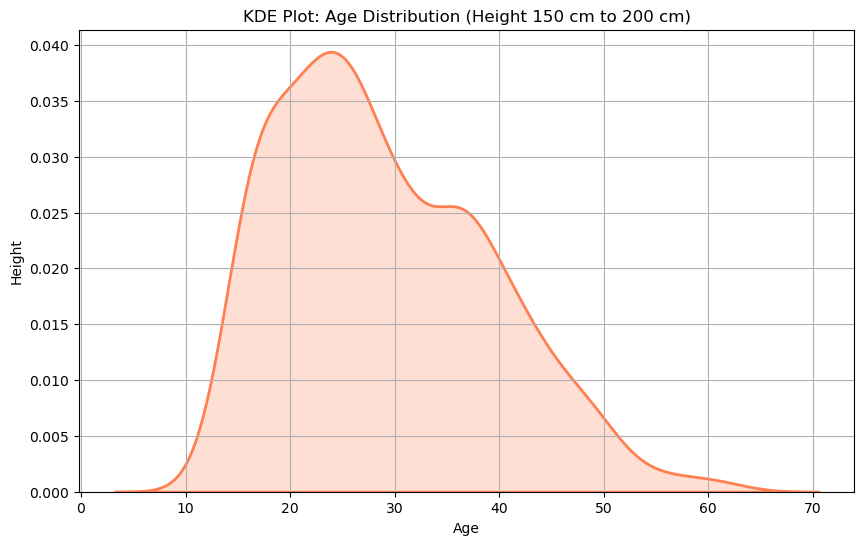

In [10]:
#Filter based on height range
df1_filtered = df1[(df1['Height'] >= 150) & (df1['Height'] <= 200)]

# KDE Plot of Age
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df1_filtered, x='Age', fill=True, color='coral', linewidth=2)
plt.title('KDE Plot: Age Distribution (Height 150 cm to 200 cm)')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()
